### Fixes

* performance (`DetectionResults.detections_by_class` memoized)
* performance (`DetectionResults.num_gt_class` memoized)
* "crowd" GT detection handling (OK for T_IoU = 0.5 at least!)

### To do

* "crowd" GT detection handling
* per-class mAP
* per-class AP
* small / medium / large AP...

In [1]:
import sys; sys.path.append("..")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from evaldets.api import *
from uo.utils import *

In [2]:
dr = DetectionResults('~/reval_05/baseline_05/evaluator_dump_R101_101/', area_rng=None, iou_thresh=None, cache=0)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=36.82s).


In [3]:
dr.mean_average_precision()

0.6025011979805461

In [4]:
dr.finish_cocoeval()

Accumulating evaluation results...
DONE (t=7.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

This doesn't work without re-computing object ids with new IoU:

In [24]:
dr.mean_average_precision(0.75)

0.4268057493526962

In [25]:
np.mean([dr.mean_average_precision(t) for t in dr.IOU_THRS])

0.39940777717605913

In [26]:
np.mean([dr.average_precision('person', t) for t in dr.IOU_THRS])

0.5257611245854098

In [27]:
# TxRxKxAxM
np.shape(dr.coco.eval["precision"][0, :, 0, 0, -1])

(101,)

In [28]:
q1 = dr.pr_curve('person')
q1[:5], q1[-5:]

(array([1.        , 0.99877601, 0.99877601, 0.99877601, 0.99877601]),
 array([0., 0., 0., 0., 0.]))

In [29]:
cq = dr.coco.eval["precision"][0, :, 0, 0, -1]
cq[:5], cq[-5:]

(array([1.        , 0.99877601, 0.99877601, 0.99877601, 0.99877601]),
 array([0., 0., 0., 0., 0.]))

Figure saved to 2021-06-27-AP-manual-vs-cocoapi-1-R101-101-PR-curve.png and 2021-06-27-AP-manual-vs-cocoapi-1-R101-101-PR-curve.pdf


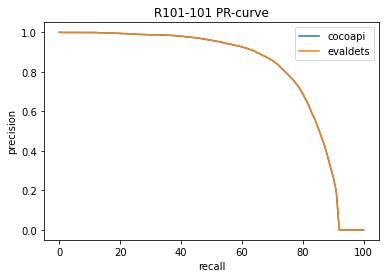

In [30]:
plt.plot(cq[:], label="cocoapi")
plt.plot(q1[:], label='evaldets')
plt.title("R101-101 PR-curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
save_plot(plt.gcf(), "2021-06-27-AP-manual-vs-cocoapi-1-R101-101-PR-curve")

In [31]:
np.mean(dr.coco.eval["precision"][0, :, 0, 0, -1])

0.8071831344949841

In [32]:
dr.average_precision('person')

0.8071831344949841

In [33]:
dr.coco.eval.keys()

dict_keys(['params', 'counts', 'date', 'precision', 'recall', 'scores'])

In [34]:
dr.num_gt_class('person')

10777

In [35]:
len(dr.detections_by_class('person'))

63997

In [36]:
len(dr.all_detections_by_class('person'))

72083

In [37]:
dets = dr.all_detections_by_class('person')

In [38]:
CROWD_ID_T = 10 ** 9
TP = np.cumsum([(det.get("iou", 0) >= 0.5 and det.get('gt_id', 0) < CROWD_ID_T) for det in dets]).astype(float)
TP.shape

(72083,)

In [39]:
FP = np.cumsum([(det.get("iou", 0) < 0.5 and det.get('gt_id', 0) < CROWD_ID_T) for det in dets]).astype(float)

In [40]:
FP

array([    0.,     0.,     0., ..., 54150., 54151., 54152.])